<!-- # Entrega Laboratorio: Eliminación de anomalías de la imagen. -->

**[Repositorio de Github](https://github.com/gen1897/Percepcion/tree/main/Color%20Cast)**
#### Participantes:  
- Cabello De Los Cobos De Toro, Luís.  
- Ferrer Cebrian, Gregorio.  
- Lopez Almazan, Hector.  
- Reche Urrutia, Jon Ander.    

### Entrega Laboratorio: Eliminación de anomalías de la imagen. <a name="introduction" />

#### Definición del artefacto a resolver.

El artefacto que se ha querido resolver es el conocido como Color Cast y algunas de sus variaciones.
Este artefacto es originado por el entorno en el que se toma la imagen, donde la luz ambiente tiñe la imagen de ese color.    
Otro artefacto relacionado con el Color Cast es la sobre/infraexposición que se produce cuando en el momento de tomar la fotografía se captura demasiada o poca luz, lo que hace que la imagen se sature y resulte en zonas demasiado brillantes. Ante estas situaciones, el histograma del canal de color saturado se encuentra volcado a la parte de los colores claros.  
#### Objetivos 
- Analisis imagenes por canales de color (obtención de histogramas e información)
- Interpolación de la función de distribución de la imagen a la función de distribución acumulada perteneciente a una distribución uniforme.
- Autocontraste.

### 1. Preparación del entorno <a name="1"> 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple
import cv2
from skimage import img_as_ubyte, img_as_float
from skimage.io import imread, imshow, imsave
from skimage.exposure import histogram, cumulative_distribution
from scipy.stats import norm
from Exploration import Exploration
from Contrast import Contrast
import warnings
warnings.filterwarnings("ignore")
contrast = Contrast()
exploration = Exploration()
images_path = []
images = []
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        images_path.append(os.path.join(dirname, filename))
        images.append(imread(os.path.join(dirname, filename)))
plt.rcParams['figure.figsize'] = 5, 3

### 2. Artefacto <a name="2">
#### Estadisticas de los canales de cada imagen

In [2]:
exploration.describe(images_path[0])

,Channel,Min,Max,Mean,Median,Std,Sum,P_01,P_05,P_10,P_90,P_95,P_99
Si_1.jpg,Red,3,255,158,176,55,56850379,17.0,46.0,83.0,217.0,236.0,252.0
Si_1.jpg,Green,0,255,121,133,53,43442732,1.0,24.0,53.0,182.0,208.0,228.0
Si_1.jpg,Blue,0,255,83,89,56,29923903,0.0,0.0,4.0,156.0,187.0,213.0


### 3. Ajuste de imagen. <a name="3">  
#### 3.1. Interpolación <a name="3.1">  
Para realizar el balance de los distintos canales, hemos escogido una imagen con tono frio para conseguir asi dar más variedad de colores o un tono más calido a esta imagen.

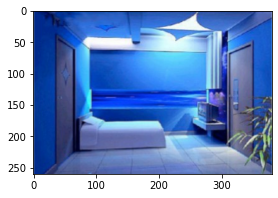

In [3]:
plt.imshow(images[2]);

Al observar los histogramas de los distintos canales de la imagen podemos observar como el canal rojo destaca por sus bajar intensidad mientras el canal azul destaca por tener la mayoria de valores en la segunda mitad del histograma. Debido a esto se le da un tono frío a la imagen la cual, mediante el canal verde, gana algo de brillo.

In [4]:
exploration.describe(images_path[2])

,Channel,Min,Max,Mean,Median,Std,Sum,P_01,P_05,P_10,P_90,P_95,P_99
Sí_3.jpg,Red,0,255,71,63,57,7062822,0.0,0.0,2.0,149.0,178.0,241.0
Sí_3.jpg,Green,0,255,113,103,56,11157014,9.0,40.0,49.0,195.0,224.0,251.0
Sí_3.jpg,Blue,23,255,185,187,49,18228862,52.0,100.0,119.0,249.0,252.0,255.0


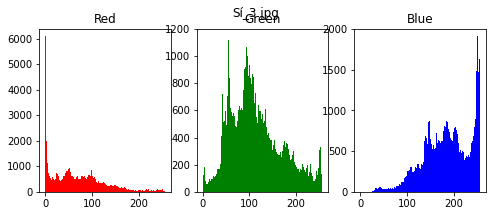

In [5]:
exploration.color_hist(images_path[2])

Al observar las distribuciones acumuladas se observa este hecho nuevamente.

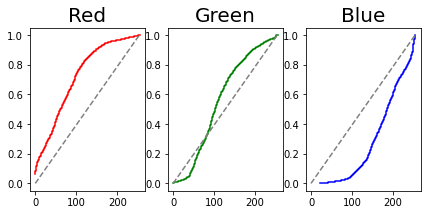

In [6]:
exploration.cumulative_distribution_comparation(images_path[2])

Para poder aplicar el balance de colores, es necesario corregir el rango dinamico de los distintos canales, pues las intensidad no tiene porque encontrarse todas entre 0 y 255, pudiendo abarcar un rango inferior de valores.

In [7]:
ceros = np.zeros(images[2].shape)
ceros[:,:,0] = (np.vectorize(contrast.normalize)(images[2][:,:,0],images[2][:,:,0].min(),images[2][:,:,0].max(),255))
ceros[:,:,1] = (np.vectorize(contrast.normalize)(images[2][:,:,1],images[2][:,:,1].min(),images[2][:,:,1].max(),255))
ceros[:,:,2] = (np.vectorize(contrast.normalize)(images[2][:,:,2],images[2][:,:,2].min(),images[2][:,:,2].max(),255))

img = ceros.astype(np.uint8)

Despues de corregir el rango, podemos ver que, a diferencia de antes, el canal azul tendra un valor de intensidad minimo igual a 0.

In [8]:
exploration.describe(img, read=False)

,Channel,Min,Max,Mean,Median,Std,Sum,P_01,P_05,P_10,P_90,P_95,P_99
0,Red,0,255,71,63,57,7062822,0.0,0.0,2.0,149.0,178.0,241.0
1,Green,0,255,113,103,56,11157014,9.0,40.0,49.0,195.0,224.0,251.0
2,Blue,0,255,177,180,54,17489238,31.0,84.0,105.0,248.0,251.0,255.0


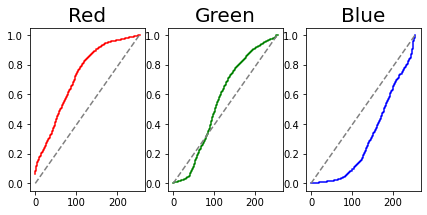

In [9]:
exploration.cumulative_distribution_comparation(img, read=False)

A continuación se especificaran paramatros para realizar la interpolación y imagenes de los distintos canales por separado.

In [10]:
target_bins = np.arange(255)
target_freq = np.linspace(0, 1, len(target_bins))
freq_bins = [cumulative_distribution(img[:,:,i]) for i in range(3)]
names = ['Reds', 'Greens', 'Blues']
line_color = ['red','green','blue']
adjusted_figures = []
f_size = 20

Al interpolar se reduce/ensalza la intensidad máxima/mínima ajustandose a la función acumulada de una distribución uniforme consiguiendo asi ecualizar la imagen. 

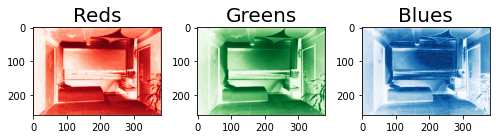

In [11]:
# Interpolacion y visualizacion de las imagenes
fig, ax = plt.subplots(1,3, figsize=[7,3])
for n, ax in enumerate(ax.flatten()):
    # Lo que queremos interpolar son las y, por eso esta al reves, nos da un objeto interpolacion que lo que hacemos es poner lo que queremos interpolar, y los ejes donde queremos sacar dichos puntos
    target_bins = np.arange(0,img[:,:,n].max())
    target_freq = np.linspace(0, 1, len(target_bins))
    interpolation = np.interp(freq_bins[n][0], target_freq, target_bins) # (a,x,y) a->The x-coordinates at which to evaluate the interpolated values. 
    adjusted_image = img_as_ubyte(interpolation[img[:,:,n]].astype(int))
    ax.set_title(f'{names[n]}', fontsize = f_size)
    ax.imshow(adjusted_image, cmap = names[n])
    adjusted_figures.append([adjusted_image])    
fig.tight_layout() 

Después de ajustar la imagen, juntamos los distintas canales en una sola imagen. 
Los histogramas acumulados nos muestran como se han equilibrado las intensidades entre los distintos colores y se han corregido posibles desbalances. La nueva función acumulada es aproximadamente la equación de una recta.

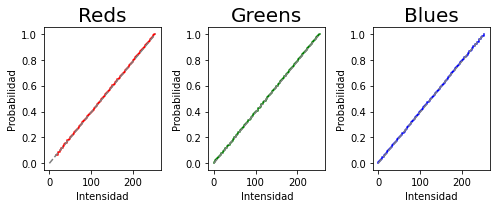

In [12]:
# Creacion de los graficos interpolados
fig, ax = plt.subplots(1,3, figsize=[7,3])
for n, ax in enumerate(ax.flatten()):
    interpolation = np.interp(freq_bins[n][0], target_freq, target_bins)
    adjusted_image = img_as_ubyte(interpolation[img[:,:,n]].astype(int))
    freq_adj, bins_adj = cumulative_distribution(adjusted_image)
    ax.set_ylabel('Probabilidad')
    ax.set_xlabel('Intensidad')
    ax.set_title(f'{names[n]}', fontsize = f_size)
    ax.step(bins_adj, freq_adj, c=line_color[n], label='Actual CDF')
    ax.plot(target_bins, target_freq, c='gray', label='Target CDF',linestyle = '--')
fig.tight_layout()

Al mostrar la imagen original y la imagen ecualizada,vemos como se ha logrado asi nuestro objetivo de obtener una mayor variedad de colores dando un aspecto más real a la imagen.

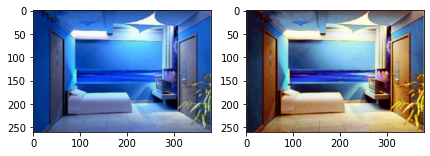

In [13]:
img_aj = np.dstack((adjusted_figures[0][0],adjusted_figures[1][0],adjusted_figures[2][0]));
fig, ax = plt.subplots(1,2, figsize=[7,3]);
ax[0].imshow(img);
ax[1].imshow(np.dstack((adjusted_figures[0][0],adjusted_figures[1][0],adjusted_figures[2][0])));

#### 3.2. Autocontraste <a name="3.2">



A continuacion vamos a mostrar la imagen a la que se le va a aplicar la técnica del autocontraste. Como se puede observar, esta imagen tiene un tono de luz cálida, por lo que el objetivo del autocontraste es eliminar esta tonalidad y conseguir que la imagen tenga una luz más natural.

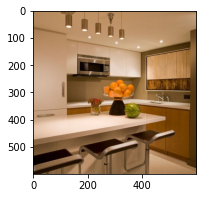

In [14]:
plt.imshow(images[0]);

Antes de aplicar el autocontraste vamos a mostrar tanto el histograma como la función de distribución acumulada por cada canal de color (RGB). En los histogramas se puede observar lo reflejado en la imagen, el color azul tiene menos píxeles con intensidades elevadas, al contrario que el color rojo. Esto provoca el efecto de luz cálida comentado anteriormente.

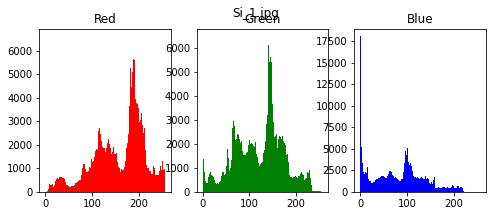

In [15]:
exploration.color_hist(images_path[0]);

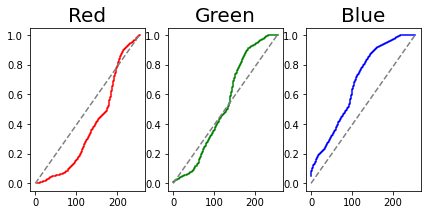

In [16]:
exploration.cumulative_distribution_comparation(images_path[0]);

Para aplicar el autocontraste primero necesitamos calcular las nuevas intensidades máximas y mínimas. Para realizar este cálculo se se han utilizado los cuantiles de la función de distribución acumulada de cada canal y como se muestran a continuación:

$$\small{a_{low} = min\{i|H(i)≥M⋅N⋅s_{low}}\}$$
$$\small{a_{high} = max\{i|H(i)≤M⋅N⋅(1−s_{high})}\}$$

Para la intensidad mínima se eliminará un pequeño porcentaje de los píxeles de intensidades inferiores y se obtendrá la nueva intensidad mínima. De la misma forma, para la intensidad máxima se eliminará un porcentaje de los píxeles con las intensidades más altas y se obtendrá la nueva intensidad máxima.

In [17]:
img_R, img_G, img_B = images[0][:, :, 0], images[0][:, :, 1], images[0][:, :, 2]

In [18]:
cdf_R, cdf_G, cdf_B = contrast.compute_cdfs(img_R, img_G, img_B)

In [19]:
a_low_R, a_high_R = contrast.search_limits(cdf_R, 0.02, 0.02)
a_low_G, a_high_G = contrast.search_limits(cdf_G, 0.01, 0.01)
a_low_B, a_high_B = contrast.search_limits(cdf_B, 0.01, 0.01)

In [20]:
a_low_R, a_high_R

(26, 249)

Eliminando un 2\% por cada lado, la nueva intensidad mínima del color rojo pasa a ser la 26, mientras que la máxima pasa a ser la 248. Esto quiere decir que existía mayor número de píxeles en intensidades altas que en bajas, lo que cuadra con el histograma y la función de distribución acumulada. 

In [21]:
a_low_G, a_high_G

(1, 228)

In [22]:
a_low_B, a_high_B

(0, 213)

Una vez que tenemos el nuevo rango de intensidades para cada canal, debemos realizar el mapeo correspondiente. Para realizar el mapeo utilizaremos la siguiente ecuación:

$$
f(a)=
\small{\begin{cases}
  a_{min} \text{ for }a\leq a_{low}\\    
  a_{min} + (a - a_{low}) \cdot \frac{a_{max} - a_{min}}{a_{high} - a_{low}} \text{ for } a_{low} < a < a_{high}\\
  a_{max} \text{ for }a\geq a_{high}\\ 
\end{cases}}
$$  
$$
f(a)=
\small{\begin{cases}
  0 \text{ for }a\leq a_{low}\\    
  0 + (a - a_{low}) \cdot \frac{255}{a_{high} - a_{low}} \text{ for } a_{low} < a < a_{high}\\
  255 \text{ for }a\geq a_{high}\\ 
\end{cases}}
$$

Esta ecuación asignara un 0 para intensidades que caigan por debajo de la nueva intensidad mínima, mientras que para intensidades que sean superiores a la nueva intensidad máxima asignara un 255 (ya que usamos 8 bits). Para las intensidades que caigan entre los valores máximos y mínimos calcula el mapeo de su nuevo valor.

In [23]:
new_data_R = np.vectorize(contrast.autocontrast)(img_R, a_low_R, a_high_R).astype(np.uint8)
new_data_G = np.vectorize(contrast.autocontrast)(img_G, a_low_G, a_high_G).astype(np.uint8)
new_data_B = np.vectorize(contrast.autocontrast)(img_B, a_low_B, a_high_B).astype(np.uint8)

In [24]:
new_data_R.min(), new_data_R.max()

(0, 255)

In [25]:
new_data_G.min(), new_data_G.max()

(0, 255)

In [26]:
new_data_B.min(), new_data_B.max()

(0, 255)

Como se puede observar el mapeo de intensidades ha sido satisfactorio y los nuevos canales de colores vuelven a estar en el rango de $[0-255]$.  
A continuación se va a crear la nueva imagen autocontrastada para ver el resultado.

In [27]:
new_image = contrast.create_new_RGB_image(images[0].shape, new_data_R, new_data_G, new_data_B)

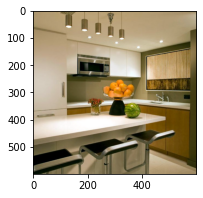

In [28]:
plt.imshow(new_image);

Se puede apreciar que el resultado es satisfactorio, la imagen ya no tiene el efecto de luz cálida. Para finalizar, se va a mostrar tanto el histograma como la función de distribución acumulada de cada canal.

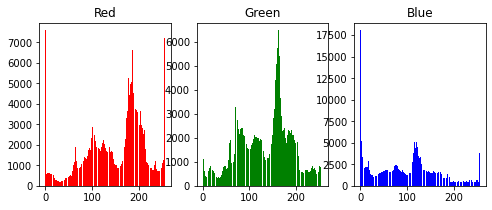

In [29]:
exploration.color_hist(new_image, read=False)

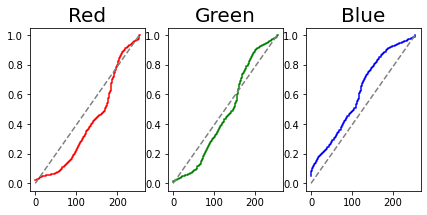

In [30]:
exploration.cumulative_distribution_comparation(new_image, read=False)

Los histogramas de cada canal han expandido todo su rango de píxeles al rango $[0-255]$. En el caso de las funciones de distribución acumuladas, la curva se ha aplanado un poco acercándose a la de una distribución uniforme. Dado que esto no es la equalización del histograma, estos resultados son los esperados.
### 4. Conclusiones <a name="4">  
Tras haber conseguido implementar correctamente dos metodos para corregir este artefacto, hemos comprobado si la imagen se vería mejorada con la combinación de ambos algoritmos. Observamos mejores sombras e iluminación.

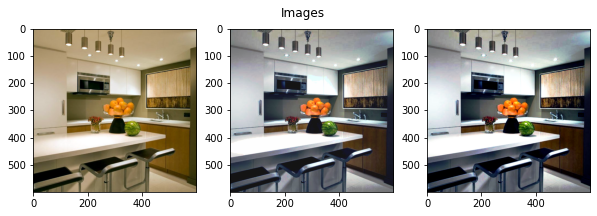

In [31]:
ecualizacion_autoajuste = contrast.rgb_adjuster_lin(contrast.color_balance_RGB_image(images_path[0]), plot=False, read=False);
autoajuste_ecualizacion = contrast.color_balance_RGB_image(contrast.rgb_adjuster_lin(images_path[0], plot=False), read=False);
fig, axs = plt.subplots(1,3,figsize=(10,3));
fig.suptitle("Images");
axs[0].imshow(new_image);
axs[1].imshow(ecualizacion_autoajuste);
axs[2].imshow(autoajuste_ecualizacion);

### 5. Referencias
- [Color Balancing Algorithms](https://web.stanford.edu/~sujason/ColorBalancing/simplestcb.html)
- [Color Channel Histogram Manipulation for Beginners](https://towardsdatascience.com/introduction-to-image-processing-with-python-color-channel-histogram-manipulation-for-beginners-d1d77dcb998d)
- [Introduction to Image Processing with Python](https://towardsdatascience.com/introduction-to-image-processing-with-python-histogram-manipulation-for-beginners-8b107d4c4fef)